In [1]:
import matplotlib.pyplot as plt
from utils import *

from synphot import Observation, SourceSpectrum, SpectralElement, units
from synphot.models import BlackBodyNorm1D
from specutils import Spectrum1D
from astropy.io import fits, ascii
import pysynphot as ps
import os

#Look at the filters included in synphot
#filter transmission profiles are saved in j,h,k



# Reads in 2MASS Filter Profiles, Ended up not needing this - will delete in final tool

# from synphot import SpectralElement
# j = SpectralElement.from_filter('bessel_j')  
# h = SpectralElement.from_filter('bessel_h')  
# k = SpectralElement.from_filter('bessel_k')
# plt.plot(j.waveset, j(j.waveset), 'b', h.waveset, h(h.waveset), 'r', k.waveset, k(k.waveset), 'k') 

# plt.ylim(0, 1.1)  
# # Label comes from DESCRIP keyword from FITS header
# plt.legend([j.meta['header']['descrip'], h.meta['header']['descrip'],k.meta['header']['descrip']]) 

/opt/anaconda3/lib/python3.8/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/opt/anaconda3/lib/python3.8/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


In [2]:
#display all available jwst filter profiles for reference
filter_dir = "/Users/connorvancil/Desktop/AstroResearch/Data/models/filters/"

instrument_directories= {'nircam':"JWST_coronagraphy/",
                         'miri':"JWST_coronagraphy/MIRI/MIRI-",
                         'nirc2':'MKO_WISE_IRAC/',
                         'niriss':'JWST_coronagraphy/NIRISS/NIRISS-',
                         'nircam_phot':'JWST_photometry/'}

#photometry modes are included in mask directory
nircam_mask_directories = {'mask210r':'NIRCAM_MASK210R/NIRCAM-',
                    'mask335r':'NIRCAM_MASK335R/NIRCAM-',
                    'mask430r':'NIRCAM_MASK430R/NIRCAM-',
                    'masklwb':'NIRCAM_MASKLWD/NIRCAM-',
                    'maskswb':'NIRCAM_MASKSWB/NIRCAM-',
                    'moda':'NIRCAM_modA/NIRCAM-','modb':'NIRCAM_modB/NIRCAM-',
                    'modab':'NIRCAM_modAB_mean/NIRCAM-'}

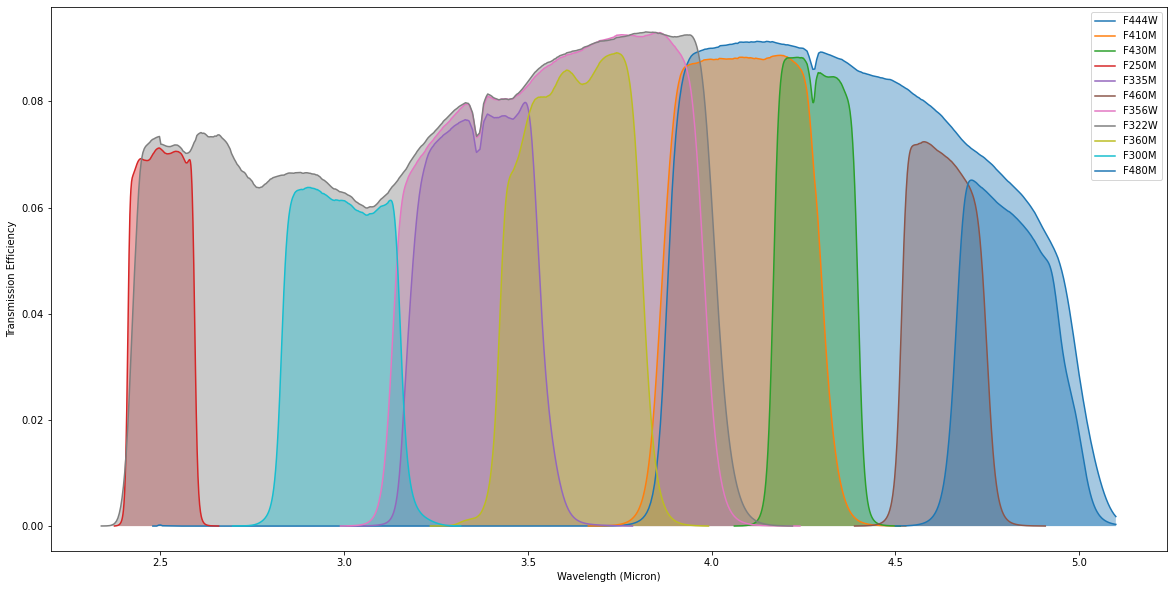

In [3]:
filter_dir = "/Users/connorvancil/Desktop/AstroResearch/Data/models/filters/"
instrument='nircam'
instrument_mask = 'mask335r'


filter_dir+=instrument_directories.get(instrument.lower())+ 'NIRCAM_MASK335R/'

filters=os.listdir(filter_dir)
plt.figure(figsize=(20,10))
for filter in filters:
    file = filter_dir + filter
    f = open(file,'r')
    lines=f.readlines()[2:]
    wvs=[];transmission=[];
    for line in lines:
        wvs.append(float(line.split()[0]))
        transmission.append(float(line.split()[1]))
    plt.plot(wvs,transmission,label=filter[7:12])
    plt.fill_between(wvs,0,transmission,alpha=0.4)
    
plt.legend();plt.ylabel("Transmission Efficiency"); plt.xlabel("Wavelength (Micron)");

### Simple function to grab some transmission filters of a given NIRCAM mask

###### should work for all filters, if not I can fix

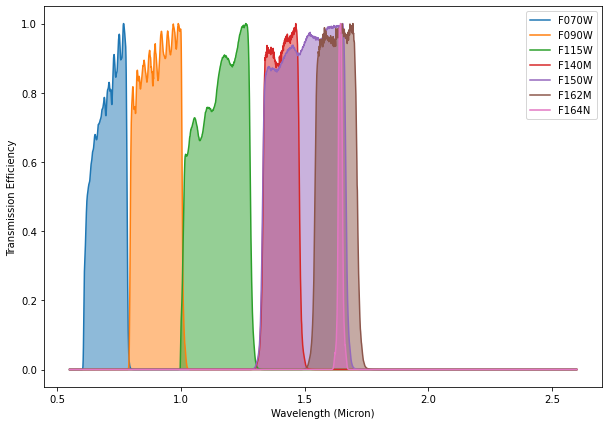

In [4]:
from astropy import units as u
from synphot import Observation, SourceSpectrum, SpectralElement, units
from specutils import Spectrum1D

filter_dir="/Users/connorvancil/Desktop/AstroResearch/Data/models/filters/"

def get_filter_profiles_normalized(instrument,filter_names, mask = None,filter_dir = filter_dir,plot=True):
    profiles=[]
    
    filter_dir+=instrument_directories.get(instrument.lower())
    if mask is not None:
        filter_dir+=nircam_mask_directories.get(mask.lower())
        
        
    if plot==True:
        plt.figure(figsize=(10,7))
    
    for filter_name in filter_names:
        
        filt = filter_name.upper()+'.txt';file = filter_dir + filt
        f = open(file,'r')
        lines=f.readlines()[2:]
        wvs=[];transmission=[];
        for line in lines:
            wvs.append(float(line.split()[0]))
            transmission.append(float(line.split()[1]))
        transmission/=np.max(transmission)
        if plot==True:
            plt.plot(wvs,transmission,label=filter_name.upper())
            plt.fill_between(wvs,0,transmission,alpha=0.5)
            plt.ylabel("Transmission Efficiency"); plt.xlabel("Wavelength (Micron)");

        #might as well wave the transmission profiles as synphot Spectral Elements
        spec=Spectrum1D(spectral_axis = wvs*u.micron,flux=transmission*u.dimensionless_unscaled)
        bp = SpectralElement.from_spectrum1d(spec)
        profiles.append(bp)
        
    if plot==True:
        plt.legend()
        
        
    return profiles


jwst_phot_modA = get_filter_profiles_normalized('nircam_phot',['f070w','f090w','f115w','f140m','f150w','f162m','f164N'],mask='moda')


### Pickles Spectrum Read-In

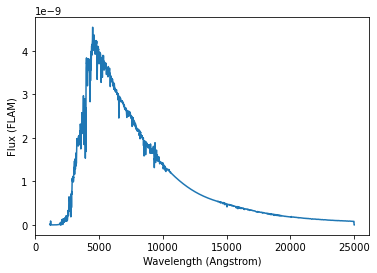

In [5]:
def get_pickles_spectrum(spt,verbose=True):
    '''
    A function that retuns a pysynphot pickles spectrum for a given spectral type
    '''

    #Read in the pickles master list. 
    pickles_dir = "/Users/connorvancil/Desktop/AstroResearch/Data/trds/grid/pickles/dat_uvk/"
    pickles_filename = pickles_dir+"pickles_uk.fits"
    pickles_table = np.array(fits.open(pickles_filename)[1].data)
    pickles_filenames = [x[0].decode().replace(" ","") for x in pickles_table]
    pickles_spts = [x[1].decode().replace(" ","") for x in pickles_table]
    
    #The spectral types output by EXOSIMS are sometimes annoying
    spt=spt.upper()
    spt = spt.replace(" ","").split("/")[-1]

    #Sometimes there are fractional spectral types. Rounding to nearest integer
    spt_split = spt.split(".")
    if np.size(spt_split) > 1: 
        spt = spt_split[0] + spt_split[1][1:]

    #Get the index of the relevant pickles spectrum filename
    try: 
        ind = pickles_spts.index(spt)
    except: 
        if verbose:
            print("Couldn't match spectral type {} to the pickles library".format(spt))
            print("Assuming 'G0V'")
        ind = pickles_spts.index('G0V')

    sp = SourceSpectrum.from_file(pickles_dir+pickles_filenames[ind]+".fits",flux_unit='flam')

    return sp
get_pickles_spectrum('G0v').plot(flux_unit='flam')

In [6]:
#zero point dictionary for JWST Filters, might need to use for magnitude scaling, keeping for now
jwst_zps = {'f444w': 2.92e-12,'f410m': 3.86e-12,'f430m': 3.2e-12,'f250m': 2.47e-11,'f335m': 8.15e-12,
            'f460m': 2.36e-12,'f356w': 6.56e-12,'f322w2': 1.01e-11,'f360m': 6.11e-12,'f300m': 1.27e-11,
            'f480m': 2.03e-12, 'f1065c': 9.11e-14, 'f1140c': 6.94e-11, 'f1550c':1.98e-14,
            'f2300c':445e-15, 'f182m': 7.61e-11, 'f187n': 6.95e-11, 'f200w': 5.88e-11, 'f210m': 4.81e-11,
            'f212n': 4.6e-11, 'f2772': 1.73e-11, 'f380m': 4.91e-12}

In [7]:
#spit out a jwst magnitude for a given filter, spectral type, instrument, mask (if applicable)
#currently only functional for nircam mask 335R - need to update file finding function
from synphot import Observation, SourceSpectrum, SpectralElement, units
from synphot.models import BlackBodyNorm1D
from specutils import Spectrum1D
from astropy.io import fits, ascii
import pysynphot as ps

#zero points need updating for photometry modes/filters

def get_jwst_mag(spt,instrument,jwst_filt,filter_dir=filter_dir,jwst_mask=None,plot=True):
    '''
    Input:
    spec_type: 'str', spectral type of your desired object, should match a model in the pickles catalog
    jwst_filt: 'str', desired jwst filter
    
    Optional:
    spectral_type_dict: dictionary for definitions of temp based on spectral type
    zps: dict of zero points (in flam) of different filters (outdated)
    
    Output:
    mag: the calculated magnitude for input JWST filter
    
    '''
    
    src = get_pickles_spectrum(spt)

    jwst_filt = get_filter_profiles_normalized(instrument,[jwst_filt],jwst_mask,plot=plot)[0]


    obs = Observation(src, jwst_filt,force='taper');
        
    wvs=src.waveset.to('micron');
    jwstwvs=jwst_filt.waveset.to('micron')
    
    #observation works differently, force to plot in microns
    #plot in correct wavelength units
    obswv=obs.waveset.to('micron');obsspec=obs.as_spectrum()
    if plot==True:
        obsspec.plot(wavelengths=obswv,flux_unit='flam')
        src.plot(wvs,flux_unit='flam');jwst_filt.plot(jwstwvs)
    
    mag = -2.5*np.log10(obs.effstim('flam').value)
    print("effstim: {}".format(obs.effstim('flam')))
    mag = np.round(mag,2)
    
    print("{} magnitudes".format(mag))
    return mag
  
get_jwst_mag('G0V','nircam_phot','f140m',jwst_mask='moda',plot=False);    

effstim: 5.627706441288339e-10 FLAM
23.12 magnitudes


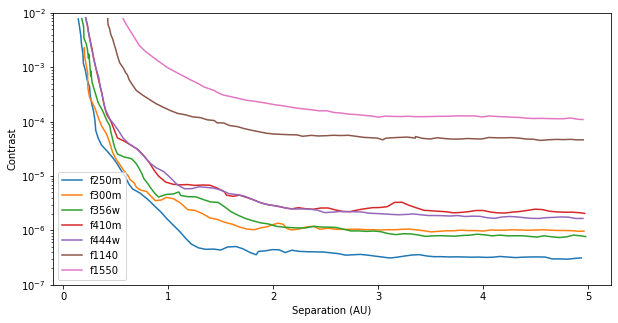

In [8]:
#read in the digitized csv files just to make sure they worked
import csv
from scipy.interpolate import interp1d
curve_dir = "/Users/connorvancil/Desktop/AstroResearch/contraster/"
av_filt=['f250m.csv','f300m.csv','f356w.csv','f410m.csv','f444w.csv','f1140c.csv','f1550c.csv']
plt.figure(figsize=(10,5));plt.ylim(1e-7,1e-2)
plt.xlabel('Separation (AU)');plt.ylabel('Contrast')

contrast_curves={}

for filt_file in av_filt:
    separation=[];contrast=[]
    with open(curve_dir+filt_file,'r') as f:
        reader=csv.reader(f)
        for row in reader:
            separation.append(float(row[0]))
            contrast.append(float(row[1]))
        f.close()
    separation=np.array(separation);contrast=np.array(contrast)
    sort=np.argsort(separation)
    separation=separation[sort];contrast=contrast[sort]
    
    interpd = interp1d(separation,contrast)
    plt.semilogy(separation,interpd(separation),label=filt_file[0:5]); 
    
    contrast_curves[filt_file[0:5]]=[separation,interpd(separation)]
plt.legend();

Tasks:

   ~~let input be a pickle model instead of a blackbody~~
    
   add distance modulus: what is assumed distance of pickle models and what is the proper scaling form?
    
   ~~After that works, output is a Star mag. Use the contrast curves above to get a minimum companion magnitude~~
   
   ~~take companion magnitude into Max's code to get out a mass~~
   
   use Max's companion list & NASA exoplanet archive to use as target lists
    
   put all into a single .py file and clean up for usability    

In [9]:
def companion_detection_limit(host_mag,jwst_filter,curves=contrast_curves,plot=True):
    '''
    Inputs:
    host_mag: 'float', magnitude of your host star in desired jwst filter
    jwst_filter: 'str', filter name
    curves: 'array', [separations, constrast] array of contrast curve if known
    
    Output:
    Separation, 'array'
    Constrast, 'array'
    '''
    
    separation,contrast = curves.get(jwst_filter[0:5].lower())
    
    companion_mag_limit = host_mag - 2.5*np.log10(contrast)
    
    if plot==True:
        plt.figure(figsize=(10,5))
        plt.plot(separation,companion_mag_limit)
        plt.ylabel('Minimum Companion Mag');plt.xlabel('Separation')
        ax = plt.gca()
        ax.set_ylim(ax.get_ylim()[::-1])
        
    return [separation,companion_mag_limit];
    

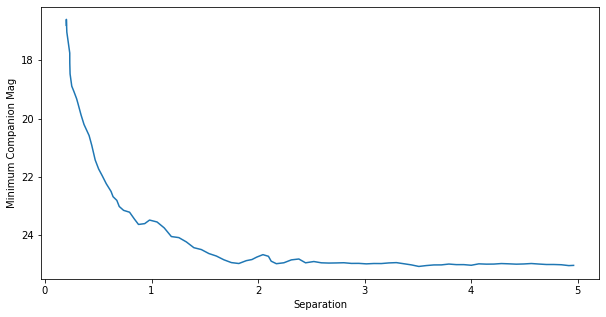

In [10]:
#try to get minimum mag from a 10 mag host star
sep, mag_limit=companion_detection_limit(10,'f300m',curves=contrast_curves,plot=True)

In [11]:
from utils import *
import glob 

instrument_directories= {'nircam':"JWST_coronagraphy/",
                         'miri':"JWST_coronagraphy/JWST_coron_MIRI/",
                        'nirc2':'MKO_WISE_IRAC/'}
instrument_mask = 'MASK335R'
nircam_mask_directories = {'mask210r':'JWST_coron_NIRCAM_MASK210R/',
                    'mask335r':'JWST_coron_NIRCAM_MASK335R/',
                    'mask430r':'JWST_coron_NIRCAM_MASK430R/',
                    'masklwb':'JWST_coron_NIRCAM_MASKLWD/',
                    'maskswb':'JWST_coron_NIRCAM_MASKSWB/',
                    }

model_dir="/Users/connorvancil/Desktop/Astroresearch/Data/models/evolutionary_tracks/ATMO_CEQ/"
instrument='nircam'
model_dir+=instrument_directories.get(instrument.lower())+nircam_mask_directories.get(instrument_mask.lower())

available_filters = get_available_filters(model_dir)
filter_name = 'f300m'

if filter_name.lower() not in available_filters:
    print("The chosen filter is not available in this instrument configuration")
    print("Please choose from:")
    print(available_filters)
    
masses, ages, mags = read_track_for_filter(model_dir,filter_name)
masses_size = len(masses)
ages_size = len(ages[0])

/Users/connorvancil/Desktop/AstroResearch/contraster/testing/utils.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(masses)[sorted_by_mass], np.array(age_list)[sorted_by_mass], np.array(mag_list)[sorted_by_mass]


(0.0, 10.0)

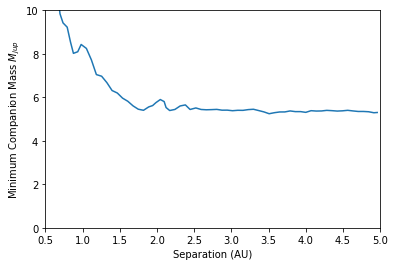

In [12]:
mass_func=get_mass_func_from_mag(ages[0][-10],1e3,masses,ages,mags)
#use the generated mass function to input your minimum mag curve -> mass limit
#give info about target_planet & can overplot this on the curve

mass_limit = mass_func(mag_limit);
plt.plot(sep,mass_limit);plt.ylabel("Minimum Companion Mass $M_{jup}$");plt.xlabel('Separation (AU)');
plt.xlim(0.5,5);plt.ylim(0,10)